In [1]:
import os
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Base directory (adjust if needed)
base_dir = "."

# Folders to iterate over (assuming numerical order from 0.1 to 1.0)
folders = [f"{i}" for i in range(6, 21)]  # Generates ['0.1', '0.2', ..., '1.0']

# Dictionary to store JSON data
data_dict = {}

for folder in folders:
    ori_path = os.path.join(base_dir, folder, "OPT.json")
    
    # Check if the file exists
    if os.path.exists(ori_path):
        with open(ori_path, "r") as f:
            data_dict[folder] = json.load(f)
    else:
        print(f"Warning: {ori_path} not found")

# Display collected data
print(data_dict)

{'6': {'braketSchemaHeader': {'name': 'braket.task_result.analog_hamiltonian_simulation_task_result', 'version': '1'}, 'taskMetadata': {'braketSchemaHeader': {'name': 'braket.task_result.task_metadata', 'version': '1'}, 'id': 'arn:aws:braket:us-east-1:849837135378:quantum-task/d3353655-bff4-4d76-8a0f-d4b50b83d708', 'shots': 1000, 'deviceId': 'arn:aws:braket:us-east-1::device/qpu/quera/Aquila', 'createdAt': '2025-03-08T21:21:51.827Z', 'endedAt': '2025-03-08T22:22:25.139Z', 'status': 'COMPLETED'}, 'measurements': [{'shotMetadata': {'shotStatus': 'Success'}, 'shotResult': {'preSequence': [1, 1, 1, 1, 1, 1], 'postSequence': [1, 0, 1, 1, 0, 1]}}, {'shotMetadata': {'shotStatus': 'Success'}, 'shotResult': {'preSequence': [1, 1, 1, 1, 1, 1], 'postSequence': [1, 1, 1, 1, 1, 1]}}, {'shotMetadata': {'shotStatus': 'Success'}, 'shotResult': {'preSequence': [1, 1, 1, 1, 1, 1], 'postSequence': [0, 1, 0, 1, 0, 1]}}, {'shotMetadata': {'shotStatus': 'Success'}, 'shotResult': {'preSequence': [1, 1, 1, 1,

In [3]:
def ob_value(bin_str1, bin_str2):
    
    if len(bin_str1) != len(bin_str2):
        raise ValueError("Binary strings must have the same length")

    # Compute bitwise product (AND operation)
    bitwise_product = [int(b1) & int(b2) for b1, b2 in zip(bin_str1, bin_str2)]

    # Compute modulo 2 sum (XOR sum of all resulting bits)
    mod2_sum = sum(bitwise_product) % 2

    return mod2_sum

def z_value(sample, size):
    Z_ob = [format(1 << i, f'0{size}b') for i in range(size)]

    Z_val = 0
    for ob in Z_ob:
        
        if ob_value(sample, ob) == 1:
            # ground state
            Z_val = Z_val - 1 
        else:
            # excited state
            Z_val = Z_val + 1

    return Z_val

def zz_value(sample, size):
    ZZ_ob = []
    for i in range(size-1):
        first_bit = 1 << i
        second_bit = 1 << ((i + 1) % size)  # Wrap around for the last element
        ZZ_ob.append(format(first_bit | second_bit, f'0{size}b'))

    ZZ_val = 0
    for ob in ZZ_ob:
        if ob_value(sample, ob) == 0:
            # 00 or 11
            ZZ_val = ZZ_val + 1
        else:
            # 01 or 10
            ZZ_val = ZZ_val - 1 

    return ZZ_val

In [4]:
exp_Zs = []
exp_ZZs = []
var_Zs = []
var_ZZs = []

# ls = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
ls = ["6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
nls = list(map(float, ls))

for item in ls:
    data = data_dict[item]
    Z_vals = []
    ZZ_vals = []

    # Extract the first measurement
    measurements = data.get("measurements", [])  # Get measurements list safely

    post_sequences = []
    for measurement in measurements:
        shot_result = measurement.get("shotResult", {})
        post_sequence = shot_result.get("postSequence", [])

        # Convert list to tuple so it can be used as a dictionary key
        binary_string = ''.join(map(str, post_sequence))
        post_sequences.append(binary_string)

    # Count the frequency of each unique postSequence
    sequence_counts = Counter(post_sequences)

    # Convert back to dictionary format
    post_sequence_dict = dict(sequence_counts)

    q_num = 6
    bitstring_counts = post_sequence_dict
    for key, value in bitstring_counts.items():
        Z_val = z_value(key, q_num)/q_num
        ZZ_val = zz_value(key, q_num)/(q_num-1)
        for _ in range(value):
            Z_vals.append(Z_val)
            ZZ_vals.append(ZZ_val)
    ## iterate this dic, add count number of Z and ZZ to the list

    
    exp_Z = sum(Z_vals) / len(Z_vals)
    var_Z = sum((x - exp_Z) ** 2 for x in Z_vals) / len(Z_vals)
    exp_ZZ = sum(ZZ_vals) / len(ZZ_vals)
    var_ZZ = sum((x - exp_ZZ) ** 2 for x in ZZ_vals) / len(ZZ_vals)
    
    exp_Zs.append(exp_Z)
    exp_ZZs.append(exp_ZZ)
    var_Zs.append(var_Z)
    var_ZZs.append(var_ZZ)


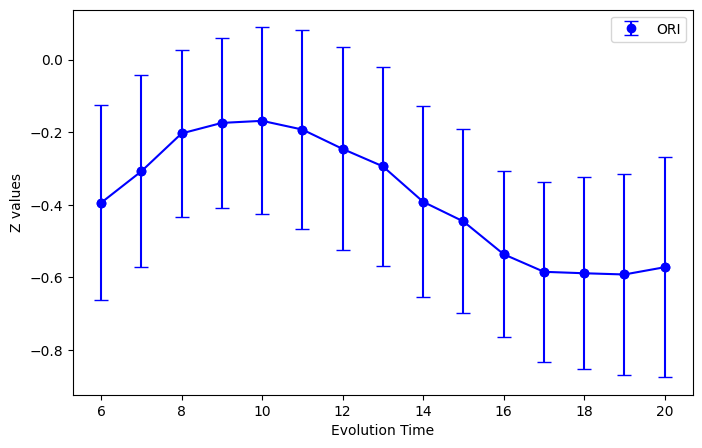

In [5]:
plt.figure(figsize=(8, 5))
plt.errorbar(nls, exp_Zs, yerr=np.sqrt(var_Zs), fmt='o', color='b', capsize=5, label="ORI")
plt.plot(nls, exp_Zs, marker='o', linestyle='-', color='b')
plt.xlabel("Evolution Time")
plt.ylabel("Z values")
plt.legend()
plt.show()

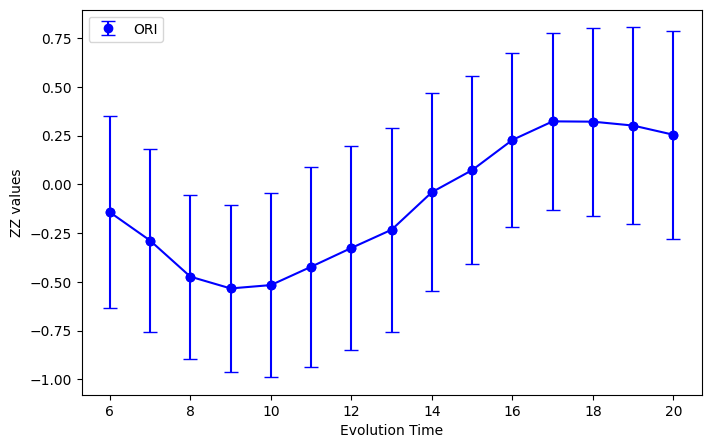

In [6]:
plt.figure(figsize=(8, 5))
plt.errorbar(nls, exp_ZZs, yerr=np.sqrt(var_ZZs), fmt='o', color='b', capsize=5, label="ORI")
plt.plot(nls, exp_ZZs, marker='o', linestyle='-', color='b')
plt.xlabel("Evolution Time")
plt.ylabel("ZZ values")
plt.legend()
plt.show()

In [7]:
data = {
    "exp_Z": exp_Zs,
    "exp_ZZ": exp_ZZs,
    "var_Z": var_Zs,
    "var_ZZ": var_ZZs
}

# Save to a JSON file
with open("opt_real.json", "w") as f:
    json.dump(data, f, indent=4)

print("Data saved successfully!")

Data saved successfully!
